In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, BatchNormalization
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

## Utility

In [2]:
class DDPGProcessor(WhiteningNormalizerProcessor):
    def process_action(self, actions):
        return np.random.choice([0,1], p=actions)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if self.training and np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super(CustomDDPGAgent, self).select_action(state)
        


## Different Configurations

In [3]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=20)
obs_shape = (20, 2)
env = env_creator()
nb_actions = env.action_space.n

def actorModel():
    model = Sequential()
    model.add(Conv2D(input_shape=(1,) + obs_shape, filters=32, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
#actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
    x = Conv2D(filters=32, kernel_size=(4,2), padding='same', activation='relu')(observation_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    flattened_observation = Flatten()(x)
    
    #flattened_observation = Flatten()(observation_input)
    y = Concatenate()([action_input, flattened_observation])
    y = Dense(512)(y)
    y = Activation('relu')(y)
    y = Dense(256)(y)
    y = Activation('relu')(y)
    y = Dense(1)(y)
    output = Activation('linear')(y)
    critic = Model(inputs=[action_input, observation_input], outputs=output)
    #print("critic")
    #critic.summary()
    return critic, action_input
#criticModel()[0].summary()
def agent_creator():
    memory = SequentialMemory(limit=2048, window_length=1)
    processor = DDPGProcessor()
    
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=1e-3)
    agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
127/989 [==>...........................] - ETA: 16s - reward: 2.3102 - cumulative_reward: 177.5024WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 3570s 4s/step - reward: -14.0095 - cumulative_reward: -581.2877
train 1 completed. took 3577.856 seconds, total_reward: -801.2000000000367 total_profit: 0.8450768853630366
min reward: -172.40000000000146, max reward: 179.39999999999844, mean_reward: -0.16189129116994072


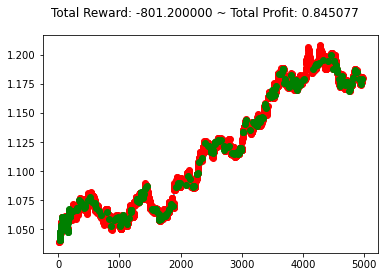

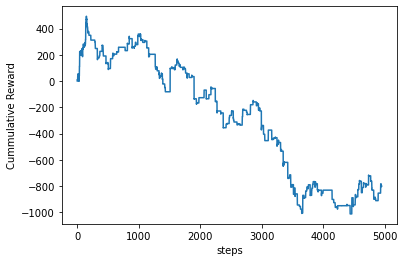

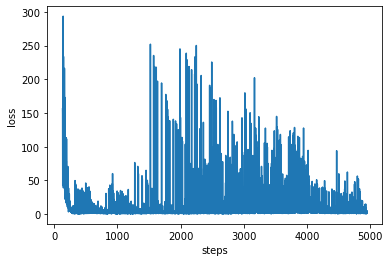

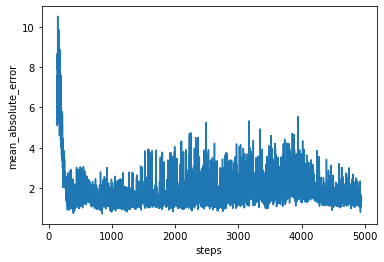

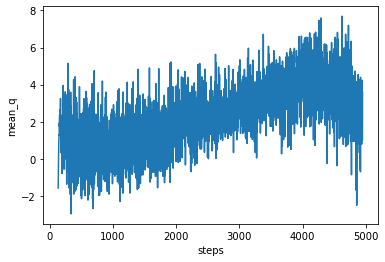

In [4]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=1)


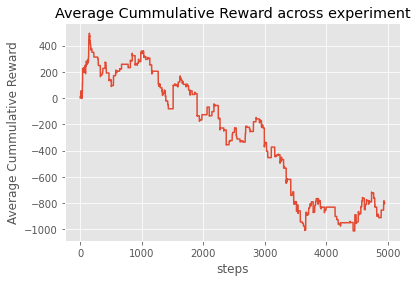

In [5]:
e.process_train_result()
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=20))

In [10]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low', 'Volume']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data

def env_creator():
    return MyForexEnv(df=FOREX_EURUSD_1H_ASK, window_size=10, frame_bound=(50, 5000))
env = env_creator()
obs_shape = (10, 5)
def actorModel():
    model = Sequential()
    model.add(Conv2D(input_shape=(1,) + obs_shape, filters=32, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
#actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
    x = Conv2D(filters=32, kernel_size=(4,2), padding='same', activation='relu')(observation_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    flattened_observation = Flatten()(x)
    
    #flattened_observation = Flatten()(observation_input)
    y = Concatenate()([action_input, flattened_observation])
    y = Dense(512)(y)
    y = Activation('relu')(y)
    y = Dense(256)(y)
    y = Activation('relu')(y)
    y = Dense(1)(y)
    output = Activation('linear')(y)
    critic = Model(inputs=[action_input, observation_input], outputs=output)
    #print("critic")
    #critic.summary()
    return critic, action_input
#criticModel()[0].summary()
def agent_creator():
    memory = SequentialMemory(limit=2048, window_length=1)
    processor = DDPGProcessor()
    
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=1e-3)
    agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])
    return agent

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 115s 116ms/step - reward: 8.4728 - cumulative_reward: 830.0176
train 1 completed. took 125.440 seconds, total_reward: 1061.9000000000174 total_profit: 0.861432111712305
min reward: -173.9999999999986, max reward: 148.9000000000007, mean_reward: 0.21456859971711809


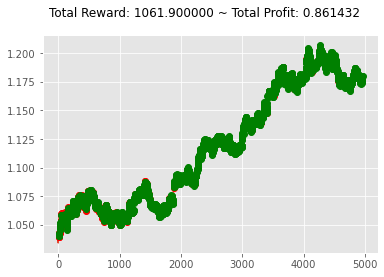

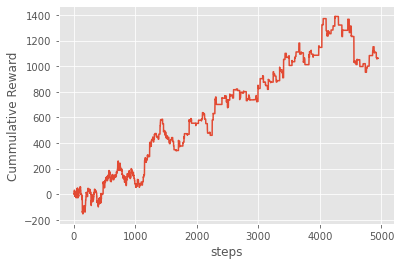

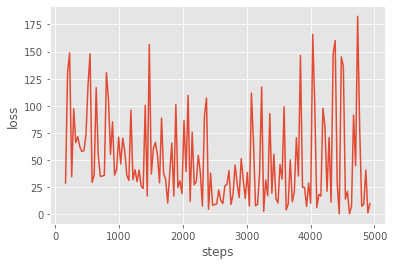

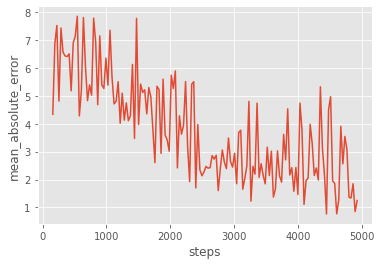

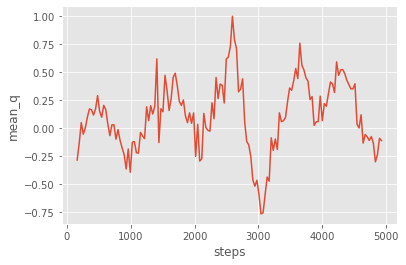

In [11]:
e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=10)

In [ ]:
e.process_train_result()
e.test(MyForexEnv(df=FOREX_EURUSD_1H_ASK, window_size=10, frame_bound=(5000, 6000)))